# Основы глубинного обучения, майнор ИАД

## Домашнее задание 1. Введение в PyTorch. Полносвязные нейронные сети.

### Общая информация

Дата выдачи: 01.10.2023

Мягкий дедлайн: 23:59MSK 15.10.2023

Жесткий дедлайн: 23:59MSK 20.10.2023

### Оценивание и штрафы
Максимально допустимая оценка за работу — 10 баллов. За каждый день просрочки снимается 1 балл. Сдавать задание после жёсткого дедлайна сдачи нельзя.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов. Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

Неэффективная реализация кода может негативно отразиться на оценке.
Также оценка может быть снижена за плохо читаемый код и плохо оформленные графики. Все ответы должны сопровождаться кодом или комментариями о том, как они были получены.

Итогова оценка считается как
$$
min(task_1, task_2)*0.8 + max(task_1, task_2)*0.2
$$

где task_1 и task_2 - оценки за первое и второе заданиее соответсвенно.
Также, за домашнее задание выставляется 0, если не сделано нулевое или третье задание.
### О задании

В этом задании вам предстоит предсказывать год выпуска песни (**задача регрессии**) по некоторым звуковым признакам: [данные](https://archive.ics.uci.edu/ml/datasets/yearpredictionmsd). В ячейках ниже находится код для загрузки данных. Обратите внимание, что обучающая и тестовая выборки располагаются в одном файле, поэтому НЕ меняйте ячейку, в которой производится деление данных.

In [208]:
import torch
from torch import nn
import torch.nn.functional as F
import pandas as pd
import numpy as np
import random
device = "cuda" if torch.cuda.is_available() else "cpu"
from tqdm.notebook import tqdm
from IPython.display import clear_output
import matplotlib.pyplot as plt

In [209]:
!wget -O data.txt.zip https://archive.ics.uci.edu/ml/machine-learning-databases/00203/YearPredictionMSD.txt.zip

--2023-10-15 20:06:53--  https://archive.ics.uci.edu/ml/machine-learning-databases/00203/YearPredictionMSD.txt.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified
Saving to: ‘data.txt.zip’

data.txt.zip            [           <=>      ] 201.24M  48.0MB/s    in 4.7s    

2023-10-15 20:06:58 (42.4 MB/s) - ‘data.txt.zip’ saved [211011981]



In [210]:
df = pd.read_csv('data.txt.zip', header=None)
df.head()

,0,1,2,3,4,5,6,7,8,9,...,81,82,83,84,85,86,87,88,89,90
0,2001,49.94357,21.47114,73.07750,8.74861,-17.40628,-13.09905,-25.01202,-12.23257,7.83089,...,13.01620,-54.40548,58.99367,15.37344,1.11144,-23.08793,68.40795,-1.82223,-27.46348,2.26327
1,2001,48.73215,18.42930,70.32679,12.94636,-10.32437,-24.83777,8.76630,-0.92019,18.76548,...,5.66812,-19.68073,33.04964,42.87836,-9.90378,-32.22788,70.49388,12.04941,58.43453,26.92061
2,2001,50.95714,31.85602,55.81851,13.41693,-6.57898,-18.54940,-3.27872,-2.35035,16.07017,...,3.03800,26.05866,-50.92779,10.93792,-0.07568,43.20130,-115.00698,-0.05859,39.67068,-0.66345
3,2001,48.24750,-1.89837,36.29772,2.58776,0.97170,-26.21683,5.05097,-10.34124,3.55005,...,34.57337,-171.70734,-16.96705,-46.67617,-12.51516,82.58061,-72.08993,9.90558,199.62971,18.85382
4,2001,50.97020,42.20998,67.09964,8.46791,-15.85279,-16.81409,-12.48207,-9.37636,12.63699,...,9.92661,-55.95724,64.92712,-17.72522,-1.49237,-7.50035,51.76631,7.88713,55.66926,28.74903


Мы вывели кусок данных, чтобы понять, насколько они пригодны для работы без изменений. Здесь ясно, что сомнительно дальше с такими данными работать, потому что как минимум есть отрицательные значения, которые не отмасштабированы, кроме того еще сразу бросается в глаза совсем разная размерность, где-то видим реально большие числа, а где-то 0.075. Ясно, что будем скейлить.

In [211]:
X = df.iloc[:, 1:].values
y = df.iloc[:, 0].values

train_size = 463715
X_train = X[:train_size, :]
y_train = y[:train_size]
X_test = X[train_size:, :]
y_test = y[train_size:]

## Задание 0. (0 баллов, но при невыполнении максимум за все задание &mdash; 0 баллов)

Мы будем использовать RMSE как метрику качества. Для самого первого бейзлайна обучите `Ridge` регрессию из `sklearn`. Кроме того, посчитайте качество при наилучшем константном прогнозе.

Для выполнения данного задания (и всех последующих) предобработайте данные.

1. Зафиксируйте random_seed везде где только возможно. Вам предоставлена функция для этого, однако вы можете дополнить ее своими дополнениями
2. Обучите StandertScaler и предобработайте ваши данные. В следующих заданиях можете использовать другой scaler или вообще отказаться от него


In [212]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

In [213]:
def set_random_seed(seed):
    torch.backends.cudnn.deterministic = True
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    # Add smth here if you need...

In [214]:
set_random_seed(42)

In [215]:
X_train # Посмотрим до масштабирования, как выглядят признаки

array([[ 4.9943570e+01,  2.1471140e+01,  7.3077500e+01, ...,
        -1.8222300e+00, -2.7463480e+01,  2.2632700e+00],
       [ 4.8732150e+01,  1.8429300e+01,  7.0326790e+01, ...,
         1.2049410e+01,  5.8434530e+01,  2.6920610e+01],
       [ 5.0957140e+01,  3.1856020e+01,  5.5818510e+01, ...,
        -5.8590000e-02,  3.9670680e+01, -6.6345000e-01],
       ...,
       [ 4.4376120e+01,  1.6253100e+00,  3.8165560e+01, ...,
        -4.3994800e+00,  2.2429410e+01, -4.1089300e+00],
       [ 4.4887230e+01,  1.4147600e+01, -5.7069400e+00, ...,
         1.1570710e+01,  1.0661509e+02,  1.6808810e+01],
       [ 5.0322010e+01,  6.7119100e+00,  5.4056070e+01, ...,
         3.7773600e+00, -4.2948880e+01,  5.2780000e-02]])

In [216]:
# Обработаем данные
X_train_scaled = scaler.fit_transform(X_train) # отмасштабировали признаки на тренировочной выборке, обучили scaler
X_test_scaled = scaler.transform(X_test) # отмасштабировали тестовые признаки, уже с помощью обученного scaler
X_train_scaled # Посмотрим, что получилось, видим, что они отмасштабировлаись

array([[ 1.07878578,  0.3915658 ,  1.82696245, ..., -0.47047696,
        -0.25536649,  0.04263679],
       [ 0.87951065,  0.33263074,  1.74896068, ...,  0.57086074,
         0.20934068,  1.16111783],
       [ 1.24551515,  0.59277085,  1.33754998, ..., -0.33808131,
         0.10782848, -0.09012209],
       ...,
       [ 0.16295616,  0.00705667,  0.83696599, ..., -0.66394994,
         0.01455343, -0.24641243],
       [ 0.2470323 ,  0.24967363, -0.40712469, ...,  0.53492495,
         0.46999692,  0.7024367 ],
       [ 1.14103808,  0.10560857,  1.28757254, ..., -0.05011829,
        -0.33914232, -0.05763319]])

In [217]:
nan_count = np.count_nonzero(np.isnan(X_train_scaled)) #Посмотрим, есть ли у нас пропуски, если что - заполним их средним значением признака
print(nan_count) # Пропусков нет (и слава богу)

0


In [218]:
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error
# В задании не сказано, нужно ли устанавливать параметр регуляризации и если да, каким он должен быть, предположим, что он равен 1
model1 = Ridge(1) # Пусть модель будет с гиперпараметром 1
model1.fit(X_train_scaled, y_train) # Обучаем
y_pred_model1 = model1.predict(X_test_scaled) #Делаем предсказание
rmse_for_model1 = np.sqrt(np.mean((y_pred_model1 - y_test)**2)) #Руками посчитали RMSE как корень средней суммы квадратов отклонений
rmse_for_model1_check = mean_squared_error(y_test, y_pred_model1, squared=False) #Нашла реализацию RMSE через sklearn.metrics
# Используем ее для того, чтобы убедиться, что наша формула верна
print(f'RMSE для модели Ridge регрессии: {rmse_for_model1}')
print(f'RMSE для модели Ridge регрессии, посчитанная другим способом: {rmse_for_model1_check}') # значения сходятся, все ок

RMSE для модели Ridge регрессии: 9.510160820470436
RMSE для модели Ridge регрессии, посчитанная другим способом: 9.510160820470436


Лучшая константа для RMSE это среднее, посчитаем значение метрики при нем

In [219]:
y_best_pred_as_mean1 = np.mean(y_train) #Нашли среднее
best_rmse_metric1 = np.sqrt(np.mean((y_best_pred_as_mean1 - y_test)**2))
print(best_rmse_metric1) #Наша модель оказалась даже лучше по RMSE

10.85246390513634


## Задание 1. (максимум 10 баллов)

Закрепите свои знания о том, как pytorch работает с обратным распространением ошибки, проделав следующие шаги:

1. Создайте модель линейной регрессии, которая будет состоять только из одного Linear слоя.
2. Напишите цикл обучения вашей линейной регрессии. В нем реализуйте подсчет функции потерь, сделайте шаг градиентного спуска. Запрещено использовать готовые оптимизаторы и loss-функции из библиотеки pytorch. Для подсчета градиента воспользуйтесь методом backward.
3. Запустите обучение на 10 эпохах, после каждой проверяйте значение целевой метрики на тестовой выборке.
4. Выведите на экран графики метрики и значения функции потерь на тестовой и обучающей выборке.

В данном задании нет цели побить какой-то порог по метрике. Ваша задача - убедиться в том, что ваш рукописный цикл обучения работает. Для ускорения вычислений и обучения модели можете брать только срез данных, а не весь датасет.

Модель через модуль nn.Module

In [220]:
scalers2= StandardScaler() # Создаем скейлер для таргета

In [221]:
X_train_scaled_1 = torch.tensor(X_train) # Преобразуем массив в тензор +для первого задания будем использовать в названих перемнных 1 (чтоб не запутаться)
X_test_scaled_1 = torch.tensor(X_test)
y_train_1 = torch.tensor(scalers2.fit_transform(y_train.reshape(-1, 1))) # Нормализуем таргет
y_test_1 = torch.tensor(y_test)

In [222]:
X_train_scaled_1 = (X_train_scaled_1).to(torch.float)
X_test_scaled_1 = (X_test_scaled_1).to(torch.float)
y_train_1 = (y_train_1).to(torch.float)
y_test_1 = (y_test_1).to(torch.float)
 # При написании обучения у меня возникла ошибка с несовпадением типа данных, поэтому переведем все в float

In [223]:
# Шаг 1 - создаем модель
class MyLinearRegression(nn.Module):
  def __init__(self, input_size):
    super(MyLinearRegression, self).__init__() #инициализация модели, наследование функций
    self.model = nn.Linear(input_size, 1)# у нас по условию 1 слой => на вход принимаем количество признаков и сразу даем результат

  def forward(self, x : torch.tensor) -> torch.tensor:
    return self.model(x) #применяем линейный слой к признакам

In [224]:
# Шаг 2 -напишем цикл обучения для 1 эпохи
def cycle_of_train(model, learning_rate, X_train, y_train):
  batch_size = 1024 # Поскольку мне не хватает ОЗУ для обучения на всей выборке, я буду разбивать ее на батчи
  numb_of_batch = (y_train.shape[0] // batch_size) + 1 # Ищем количество батчей (+1 тк у нас может быть нецелое число)
  for i in range(int(numb_of_batch)):
    for x in range(15): # Это обучение 15 раз на 1 и том же батче. Это нужно для уменьшения итоговой ошибки
      X_batch = X_train[i*int(numb_of_batch): (i+1)* int(numb_of_batch)]
      y_batch = y_train[i*int(numb_of_batch): (i+1)* int(numb_of_batch)] #Берем срез данных
      y_pred = model(X_batch) # Делаем предсказание

      y_pred_norm = torch.tensor(scalers2.inverse_transform(y_pred.detach().numpy())) #Преобразуем в нормальный вид (чтобы посчитать ошибку)
      y_batch_norm = torch.tensor(scalers2.inverse_transform(y_batch.reshape(-1, 1)))
      loss = torch.mean((y_pred - y_batch)**2) # Считаем ошибку обычную
      loss_norm = torch.mean((y_pred_norm - y_batch_norm)**2) #Считаем ошибку преобразованную в нормальный вид
      model.zero_grad() # Обнуляем градиенты, чтобы на следующем шаге опять их посчитать
      loss.backward() # Градиенты (по обычной ошибке)


      with torch.no_grad():
             for param in model.parameters():
                  param -= learning_rate * param.grad #Делаем градиентный шаг, обновляем значение параметров модели

  return loss_norm.item() #Будем возвращать нормальный лосс, это нам понадобится далее для отрисовки графиков


In [225]:
# Напишем еще функцию для проверки модели на таргете
def cycle_of_test(model, X_test, y_test):
  batch_size = 1024
  numb_of_batch = (y_test.shape[0] // batch_size) + 1
  for i in range(int(numb_of_batch)):
    X_batch = X_test[i*int(numb_of_batch): (i+1)* int(numb_of_batch)]
    y_batch = y_test[i*int(numb_of_batch): (i+1)* int(numb_of_batch)] # Здесь все то же самое
    with torch.no_grad():
         y_pred = model(X_batch) #Предсказание

         y_pred_norm = torch.tensor(scalers2.inverse_transform(y_pred.detach().numpy()))
         test_loss = torch.mean((y_pred_norm - y_batch)**2) #Лосс
         return test_loss #Возвращаем лосс
def RMSE(MSE):
  return MSE**(1/2) #Напишем функцию для упрощения кода далее, перевод MSE в RMSE

In [226]:
# Шаг 3 - запустим обучение на 10 эпохах
num_epochs = 10 # Количество эпох
model = MyLinearRegression(X_train_scaled_1.shape[1]) #Создаем нашу модель, количество признаков определяем через шейп тренировочной выборки
learning_rate = 0.00000001 # Определяем learning rate
train_losses = []
train_RMSE_losses = []
test_losses = []
test_RMSE_losses = [] #Сюда будем записывать все ошибки
for epoch in range(num_epochs): #Запускаем цикл обучения
  loss_train = cycle_of_train(model,learning_rate, X_train_scaled_1, y_train_1) #Считаем ошибку
  train_losses.append(loss_train ) # Добавляем ее в список (нужно будет для гарфиков потом)
  train_RMSE_losses.append(RMSE(loss_train)) # Преобразуем в метрику РМСЕ и тоже добавляем в список

  loss_test = cycle_of_test(model,X_test_scaled_1, y_test_1) #Тестируем модель
  test_losses.append(loss_test)
  test_RMSE_losses.append(RMSE(loss_test)) #Добавляем ошибку и РМСЕ

  print(f'Эпоха {epoch + 1}')
  print(f'Значение целевой метрики на тестовой выборке: {RMSE(loss_test)}') #Будем смотреть на метрику в тестовой выборке на каждой эпохе


Эпоха 1
Значение целевой метрики на тестовой выборке: 91.33384704589844
Эпоха 2
Значение целевой метрики на тестовой выборке: 58.70220947265625
Эпоха 3
Значение целевой метрики на тестовой выборке: 43.17267608642578
Эпоха 4
Значение целевой метрики на тестовой выборке: 34.000221252441406
Эпоха 5
Значение целевой метрики на тестовой выборке: 28.116628646850586
Эпоха 6
Значение целевой метрики на тестовой выборке: 24.176084518432617
Эпоха 7
Значение целевой метрики на тестовой выборке: 21.443923950195312
Эпоха 8
Значение целевой метрики на тестовой выборке: 19.485408782958984
Эпоха 9
Значение целевой метрики на тестовой выборке: 18.036602020263672
Эпоха 10
Значение целевой метрики на тестовой выборке: 16.933732986450195


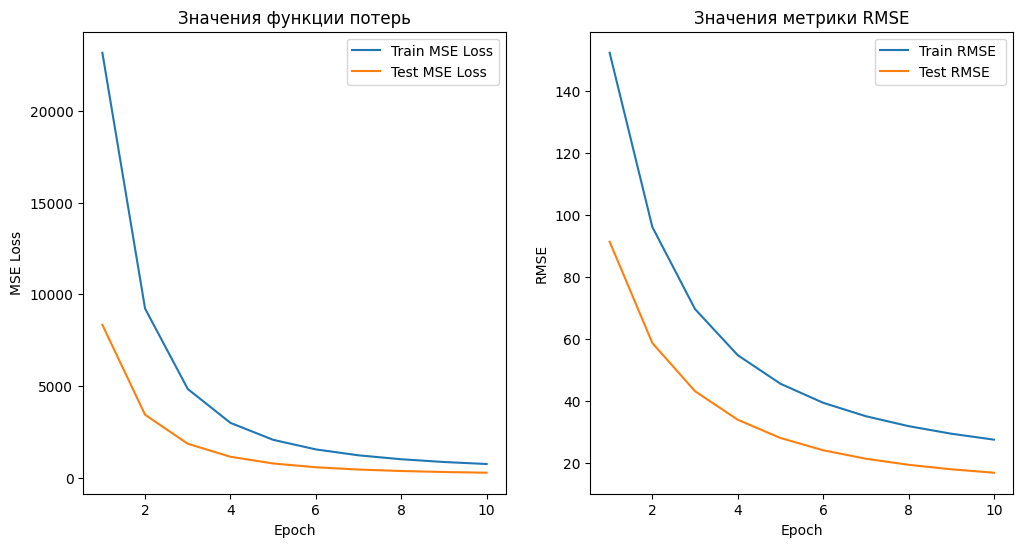

In [227]:
# Шаг 4 - нарисуем графики
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs+1), train_losses, label='Train MSE Loss')
plt.plot(range(1, num_epochs+1), test_losses, label='Test MSE Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('Значения функции потерь')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs+1), train_RMSE_losses, label='Train RMSE ')
plt.plot(range(1, num_epochs+1), test_RMSE_losses, label ='Test RMSE ')
plt.xlabel('Epoch')
plt.ylabel('RMSE')
plt.title('Значения метрики RMSE')
plt.legend()

plt.show()  # Видим, что рукописный цикл работает и модель обучается

## Задание 2. (максимум 10 баллов)

Реализуйте обучение и тестирование нейронной сети для предоставленного вам набора данных. Соотношение между полученным значением метрики на тестовой выборке и баллами за задание следующее:

- $\text{RMSE} \le 9.00 $ &mdash; 4 балла
- $\text{RMSE} \le 8.90 $ &mdash; 6 баллов
- $\text{RMSE} \le 8.80 $ &mdash; 8 баллов
- $\text{RMSE} \le 8.75 $ &mdash; 10 баллов

Есть несколько правил, которых вам нужно придерживаться:

- Весь пайплайн обучения должен быть написан на PyTorch. При этом вы можете пользоваться другими библиотеками (`numpy`, `sklearn` и пр.), но только для обработки данных. То есть как угодно трансформировать данные и считать метрики с помощью этих библиотек можно, а импортировать модели из `sklearn` и выбивать с их помощью требуемое качество &mdash; нельзя. Также нельзя пользоваться библиотеками, для которых сам PyTorch является зависимостью.

- Мы никак не ограничиваем ваш выбор архитектуры модели, но скорее всего вам будет достаточно полносвязной нейронной сети.

- Для обучения запрещается использовать какие-либо иные данные, кроме обучающей выборки.

- Ансамблирование моделей запрещено.

### Полезные советы:

- Очень вряд ли, что у вас с первого раза получится выбить качество на 10 баллов, поэтому пробуйте разные архитектуры, оптимизаторы и значения гиперпараметров. В идеале при запуске каждого нового эксперимента вы должны менять что-то одно, чтобы точно знать, как этот фактор влияет на качество.

- Не забудьте, что для улучшения качества модели вам поможет **нормировка таргета**.

- Тот факт, что мы занимаемся глубинным обучением, не означает, что стоит забывать про приемы, использующиеся в классическом машинном обучении. Так что обязательно проводите исследовательский анализ данных, отрисовывайте нужные графики и не забывайте про масштабирование и подбор гиперпараметров.

- Вы наверняка столкнетесь с тем, что ваша нейронная сеть будет сильно переобучаться. Для нейросетей существуют специальные методы регуляризации, например, dropout ([статья](https://jmlr.org/papers/volume15/srivastava14a/srivastava14a.pdf)) и weight decay ([блогпост](https://towardsdatascience.com/weight-decay-l2-regularization-90a9e17713cd)). Они, разумеется, реализованы в PyTorch. Попробуйте поэкспериментировать с ними.

- Если вы чего-то не знаете, не гнушайтесь гуглить. В интернете очень много полезной информации, туториалов и советов по глубинному обучению в целом и по PyTorch в частности. Но не забывайте, что за скатанный код без ссылки на источник придется ответить по всей строгости!

- Если вы сразу реализуете обучение на GPU, то у вас будет больше времени на эксперименты, так как любые вычисления будут работать быстрее. Google Colab предоставляет несколько GPU-часов (обычно около 8-10) в сутки бесплатно.

- Чтобы отладить код, можете обучаться на небольшой части данных или даже на одном батче. Если лосс на обучающей выборке не падает, то что-то точно идет не так!

- Пользуйтесь утилитами, которые вам предоставляет PyTorch (например, Dataset и Dataloader). Их специально разработали для упрощения разработки пайплайна обучения.

- Скорее всего вы захотите отслеживать прогресс обучения. Для создания прогресс-баров есть удобная библиотека `tqdm`.

- Быть может, вы захотите, чтобы графики рисовались прямо во время обучения. Можете воспользоваться функцией [clear_output](http://ipython.org/ipython-doc/dev/api/generated/IPython.display.html#IPython.display.clear_output), чтобы удалять старый график и рисовать новый на его месте.

**ОБЯЗАТЕЛЬНО** рисуйте графики зависимости лосса/метрики на обучающей и тестовой выборках в зависимости от времени обучения. Если обучение занимает относительно небольшое число эпох, то лучше рисовать зависимость от номера шага обучения, если же эпох больше, то рисуйте зависимость по эпохам. Если проверяющий не увидит такого графика для вашей лучшей модели, то он в праве снизить баллы за задание.

**ВАЖНО!** Ваше решение должно быть воспроизводимым. Если это не так, то проверяющий имеет право снизить баллы за задание. Чтобы зафиксировать random seed, воспользуйтесь функцией из предыдущего задания.



Вы можете придерживаться любой адекватной струкуры кода, но мы советуем воспользоваться сигнатурами функций, которые приведены ниже. Лучше всего, если вы проверите ваши предсказания ассертом: так вы убережете себя от разных косяков, например, что вектор предсказаний состоит из всего одного числа. В любом случае, внимательно следите за тем, для каких тензоров вы считаете метрику RMSE. При случайном или намеренном введении в заблуждение проверяющие очень сильно разозлятся.

In [228]:
#Проведем исследовательский анализ данных до подбора моделей
df.describe()
# Видим, что таргет у нас от 1922 до 2011 года, при этом большинство песен выпущены около 2000 года

,0,1,2,3,4,5,6,7,8,9,...,81,82,83,84,85,86,87,88,89,90
count,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,...,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000
mean,1998.397082,43.387126,1.289554,8.658347,1.164124,-6.553601,-9.521975,-2.391089,-1.793236,3.727876,...,15.755406,-73.461500,41.542422,37.934119,0.315751,17.669213,-26.315336,4.458641,20.035136,1.329105
std,10.931046,6.067558,51.580351,35.268585,16.322790,22.860785,12.857751,14.571873,7.963827,10.582861,...,32.099635,175.618889,122.228799,95.050631,16.161764,114.427905,173.977336,13.346557,185.558247,22.088576
min,1922.000000,1.749000,-337.092500,-301.005060,-154.183580,-181.953370,-81.794290,-188.214000,-72.503850,-126.479040,...,-437.722030,-4402.376440,-1810.689190,-3098.350310,-341.789120,-3168.924570,-4319.992320,-236.039260,-7458.378150,-381.424430
25%,1994.000000,39.954690,-26.059520,-11.462710,-8.487500,-20.666450,-18.440990,-10.780600,-6.468420,-2.293660,...,-1.812650,-139.555160,-20.986900,-4.669540,-6.781590,-31.580610,-101.530300,-2.566090,-59.509270,-8.820210
50%,2002.000000,44.258500,8.417850,10.476320,-0.652840,-6.007770,-11.188390,-2.046670,-1.736450,3.822310,...,9.171850,-53.090060,28.791060,33.623630,0.820840,15.598470,-21.204120,3.117640,7.759730,0.053050
75%,2006.000000,47.833890,36.124010,29.764820,8.787540,7.741870,-2.388960,6.508580,2.913450,9.961820,...,26.274480,13.478730,89.661770,77.785800,8.470990,67.794960,52.389330,9.967740,86.351610,9.679520
max,2011.000000,61.970140,384.065730,322.851430,335.771820,262.068870,166.236890,172.402680,126.741270,146.297950,...,840.973380,4469.454870,3210.701700,1734.079690,260.544900,3662.065650,2833.608950,463.419500,7393.398440,677.899630


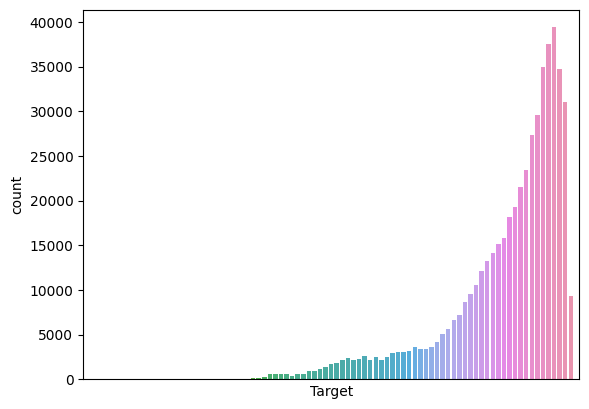

In [229]:
import seaborn as sns
sns.countplot(x=0, data=df)
plt.xticks([])
plt.xlabel('Target')
plt.show() #Видим, что распределние таргета скошено вправо, тот же вывод, что был ранее: в основном у нас таргет около 2000

In [230]:
scaler1 = StandardScaler()
scaler2 = StandardScaler() #Создадим скейлер для нормировки таргета

In [231]:
X = df.iloc[:, 1:].values
y = df.iloc[:, 0].values
set_random_seed(42)
train_size = 463715
val_size =int(0.1*train_size) #Возьмем 10 процентов трейна на валидацию
X_val = X[:val_size, :] # Определяем валидационную, тестовую и тренировочную выборку
X_train = X[val_size : train_size, :]
X_test = X[train_size:, :]

y_val = y[:val_size]
y_train = y[val_size:train_size]
y_test = y[train_size:]

In [232]:
set_random_seed(42)
X_train_scaled_2 = scaler.fit_transform(X_train)
X_val_scaled_2 = scaler.transform(X_val)
X_test_scaled_2 = scaler.transform(X_test) # Нормируем все признаки

y_train_2 = scaler2.fit_transform(y_train.reshape(-1, 1)) #Нормируем таргет


In [233]:
set_random_seed(42)
X_train_scaled_2 = torch.tensor(X_train_scaled_2).to(torch.float) #Превращаем в тезор и тип - float
X_test_scaled_2 = torch.tensor(X_test_scaled_2).to(torch.float)
X_val_scaled_2 = torch.tensor(X_val_scaled_2).to(torch.float)

y_train_2 = torch.tensor(y_train_2).to(torch.float)
y_test_2 = torch.tensor(y_test).unsqueeze(1).to(torch.float)
y_val_2 = torch.tensor(y_val).unsqueeze(1).to(torch.float)

In [234]:
from torch.utils.data import DataLoader
import torch.optim as optim
from torch.utils.data import TensorDataset
import torchvision.transforms as T
set_random_seed(47)
train_set = TensorDataset(X_train_scaled_2, y_train_2) # Соединили в датасет
test_set = TensorDataset(X_test_scaled_2, y_test_2)
test_val_set = TensorDataset(X_val_scaled_2, y_val_2)


train_loader = DataLoader(train_set, shuffle=True, batch_size=64) #Преобразовали в даталоадер, возьмем рамер батча 64
test_loader = DataLoader(test_set, shuffle=False, batch_size=32)
test_val_loader = DataLoader(test_val_set, shuffle=False, batch_size=32)

In [235]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
from tqdm.notebook import tqdm

In [236]:
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import clear_output
from tqdm.notebook import tqdm

sns.set_style('whitegrid')
plt.rcParams.update({'font.size': 15})
set_random_seed(42)
# Эту функцию мы писали на семинаре, взяла ее для отрисовки графиков, поменяла accuracy на целевую метрику - RMSE
def plot_losses(train_losses, test_losses, train_RMSE, test_RMSE):
    clear_output()
    fig, axs = plt.subplots(1, 2, figsize=(13, 4))
    axs[0].plot(range(1, len(train_losses) + 1), train_losses, label='train')
    axs[0].plot(range(1, len(test_losses) + 1), test_losses, label='test_val')
    axs[0].set_ylabel('loss')

    axs[1].plot(range(1, len(train_RMSE) + 1), train_RMSE, label='train')
    axs[1].plot(range(1, len(test_RMSE) + 1), test_RMSE, label='test_val')
    axs[1].set_ylabel('RMSE')

    for ax in axs:
        ax.set_xlabel('epoch')
        ax.legend()

    plt.show()

In [237]:
set_random_seed(42)
def train(model, optimizer, criterion, train_loader, scheduler=None):
    """
    params:
        model - torch.nn.Module to be fitted
        optimizer - model optimizer
        criterion - loss function from torch.nn
        train_loader - torch.utils.data.Dataloader with train set
        test_loader - torch.utils.data.Dataloader with test set
                      (if you wish to validate during training)
    """
    # YOUR CODE HERE (－.－)...zzzZZZzzzZZZ
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.train()

    epoch_train_loss = 0.0 # Тут будем считать общий лосс
    loss_norm_itog = 0.0 # Тут тоже лосс, но в нормальном виде

    for X_batch, y_batch in tqdm(train_loader):
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)

        optimizer.zero_grad() # Обнуляем градиенты

        y_pred = model(X_batch) # Предсказание
        y_pred_norm = torch.tensor(scaler2.inverse_transform(y_pred.detach().numpy())) #Преобразуем их в нормальный вид для подсчета нормального РМСЕ
        y_batch_norm = torch.tensor(scaler2.inverse_transform(y_batch.reshape(-1, 1)))

        loss = criterion(y_pred, y_batch) # Считаем ошибку
        loss_norm = criterion(y_pred_norm, y_batch_norm) #Считаем нормальную ошибку
        loss.backward() #Градиенты
        optimizer.step() #Шаг оптимайзера

        epoch_train_loss += loss.item() * X_batch.size(0) #Добавляем ошибку по батчу к общей сумме
        loss_norm_itog += loss_norm.item() * X_batch.size(0)

    if scheduler is not None: #Шедулер (если есть - делаем шаг)
      scheduler.step()

    epoch_loss = epoch_train_loss / len(train_loader.dataset) #Ищем среднюю ошибку
    epoch_loss_norm = loss_norm_itog / len(train_loader.dataset) #То же самое
    return [epoch_loss, epoch_loss_norm] #Будем возвращать список (я конечно epoch_loss не пользуюсь, но просто пусть будет)




def test(model, criterion, test_loader):
    """
    params:
        model - torch.nn.Module to be evaluated on test set
        criterion - loss function from torch.nn
        test_loader - torch.utils.data.Dataloader with test set
    ----------
    returns:
        predicts - torch.tensor with shape (len(test_loader.dataset), ),
                   which contains predictions for test objects
    """
    # YOUR CODE HERE (－.－)...zzzZZZzzzZZZ
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.eval()

    running_loss = 0.0 # Здесь уже сразу будем считать нормальную ошибку
    predictions = []


    with torch.no_grad():
        for inputs, targets in tqdm(test_loader): #Возьмем другие обозначения в функуию, чтоб не запутаться
            inputs = inputs.to(device) # Это Х батч
            targets = targets.to(device) # Это У батч
            y_pred_norm = model(inputs) #Предсказание
            outputs = torch.tensor(scaler2.inverse_transform(y_pred_norm.reshape(-1, 1))) #Приводим в нормальный вид
            loss = criterion(outputs, targets) #Считаем лосс

            running_loss += loss.item() * inputs.size(0) #Добавляем его в общий лосс

            predictions.extend(outputs.cpu().numpy().flatten()) #Добавляем предикты в список

    test_loss = running_loss / len(test_loader.dataset) #Средний лосс

    return [test_loss, torch.tensor(predictions)]# Здесь тоже возвращаем список, лосс мне нужен для графиков и итоговой метрики, а предикты для assert (чтоб проверить, что все ок)

In [238]:
# Это модель просто для проверки того, что все работает
model = nn.Sequential(
    nn.Linear(90, 80),
    nn.ReLU(),
    nn.Dropout(p=0.1),
    nn.Linear(80, 60),
    nn.ReLU(),
    nn.Dropout(p=0.2),
    nn.Linear(60, 45),
    nn.ReLU(),
    nn.Dropout(p=0.2),
    nn.Linear(45, 1)
) # линейный слой, преобразующий вектор размера 128 в вектор размера 10

lr = 0.001
momentum = 0.85
weight_decay = 0.001
nesterov = True
max_grad_norm = 1.0

criterion = nn.MSELoss()
# Определение оптимизатора
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum, weight_decay=weight_decay, nesterov=nesterov)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10)

In [239]:
assert test(model, criterion, test_loader)[1].shape[0] == y_test_2.shape[0] # Все работает все ок

  0%|          | 0/1614 [00:00<?, ?it/s]

Модель 1 - дала 8.75 на тестовой выборке

In [240]:
set_random_seed(1)
from torch.optim.lr_scheduler import StepLR
model = nn.Sequential(
    nn.Linear(90, 80),
    nn.ReLU(),
    nn.Dropout(p=0.1),
    nn.Linear(80, 60),
    nn.ReLU(),
    nn.Linear(60, 30),
    nn.ReLU(),
    nn.Dropout(p=0.1),
    nn.Linear(30, 1),
    ) # Сделаем 4 слоя и 2 дропаута

lr = 0.01
momentum = 0.9
weight_decay = 0.001 # Параметры для модели


criterion = nn.MSELoss() # Критерий
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum, weight_decay=weight_decay) #Оптимизатор
#scheduler = StepLR(optimizer, step_size=3, gamma=0.3) #Еще возьмем шедулер, будем уменьшать lr
scheduler = None

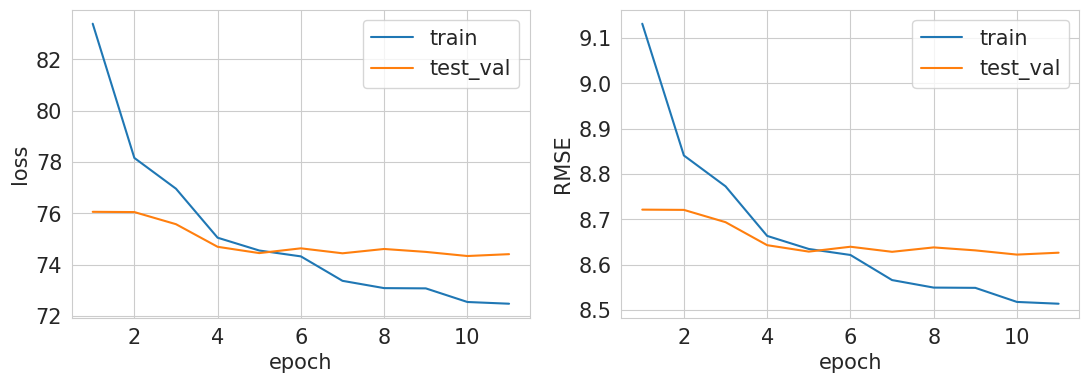

In [241]:
# ೭੧(❛〜❛✿)੭೨ Go forward!
set_random_seed(42)
train_losses, train_accuracies = [], []
val_losses, val_accuracies = [], [] # Это нужно для отрисовки графиков
otchet = [] #Это для итогового отчета

for i in range (11):
  if i % 3 == 0:
    lr = lr*(0.3) #Реализуем с "самодельным шедулером"
    for param_group in optimizer.param_groups:
            param_group['lr'] = lr
  device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
  loss_train = train(model, optimizer, criterion, train_loader, scheduler)[1] #Обучаем и берем нормальный лосс (поэтому индекс 1)
  loss_test = test(model, criterion, test_val_loader)[0] #Тестим на валидации и берем лосс (индекс 0)
  loss_test_itog = test(model, criterion, test_loader)[0]
  train_losses.append(loss_train) #Добавляем все лоссы в списки
  val_losses.append(loss_test)
  train_accuracies.append(RMSE(loss_train))
  val_accuracies.append(RMSE(loss_test))

  otchet.append(f'Epoch: {i + 1}, RMSE_train:{RMSE(loss_train)}, RMSE_test_val:{RMSE(loss_test)} \n') #Добавляем запись в отчет (в конце выведем его)

  plot_losses(train_losses, val_losses, train_accuracies, val_accuracies) #Будем рисовать графики трейна и валидации на каждой эпохе

In [242]:
print(*otchet)
loss_itog_test = test(model, criterion, test_loader)[0] # Считаем метрику на тестовой финальной выборке
print(f'Финальное RMSE, полученное на тестовой выборке: {loss_itog_test**(1/2)}')

Epoch: 1, RMSE_train:9.131435704054164, RMSE_test_val:8.721218050614961 
 Epoch: 2, RMSE_train:8.840654455676487, RMSE_test_val:8.72063397598819 
 Epoch: 3, RMSE_train:8.772662985243851, RMSE_test_val:8.693526205826862 
 Epoch: 4, RMSE_train:8.663231544764466, RMSE_test_val:8.642760857245326 
 Epoch: 5, RMSE_train:8.634400937629664, RMSE_test_val:8.62856997006199 
 Epoch: 6, RMSE_train:8.621153915153325, RMSE_test_val:8.639320601229636 
 Epoch: 7, RMSE_train:8.565765718065467, RMSE_test_val:8.628132645939214 
 Epoch: 8, RMSE_train:8.549178981148835, RMSE_test_val:8.63784649276388 
 Epoch: 9, RMSE_train:8.548610950073025, RMSE_test_val:8.631293828462757 
 Epoch: 10, RMSE_train:8.517525374230226, RMSE_test_val:8.621978436014055 
 Epoch: 11, RMSE_train:8.513584009209469, RMSE_test_val:8.626171329172056 



  0%|          | 0/1614 [00:00<?, ?it/s]

Финальное RMSE, полученное на тестовой выборке: 8.754754522374974


Модель 2 - дала 8.74 на тестовой выборке

In [243]:
set_random_seed(1)
from torch.optim.lr_scheduler import StepLR
model = nn.Sequential(
    nn.Linear(90, 80),
    nn.ReLU(),
    nn.Dropout(p=0.1),
    nn.Linear(80, 60),
    nn.ReLU(),
    nn.Linear(60, 30),
    nn.ReLU(),
    nn.Dropout(p=0.1),
    nn.Linear(30, 1),
    ) # Сделаем 4 слоя и 2 дропаута

lr = 0.01
momentum = 0.9
weight_decay = 0.001 # Параметры для модели


criterion = nn.MSELoss() # Критерий
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum, weight_decay=weight_decay) #Оптимизатор
scheduler = StepLR(optimizer, step_size=3, gamma=0.3) #Еще возьмем шедулер, будем уменьшать lr


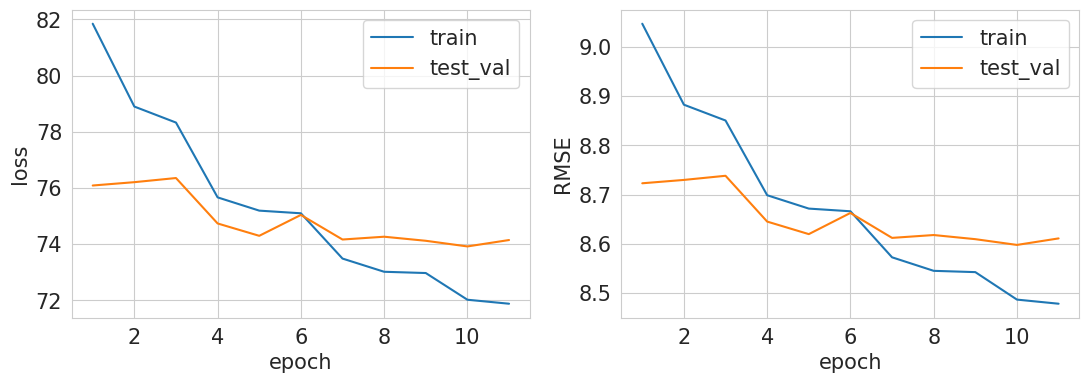

In [244]:
# ೭੧(❛〜❛✿)੭೨ Go forward!
set_random_seed(42)
train_losses, train_accuracies = [], []
val_losses, val_accuracies = [], [] # Это нужно для отрисовки графиков
otchet = [] #Это для итогового отчета

for i in range (11):
  device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
  loss_train = train(model, optimizer, criterion, train_loader, scheduler)[1] #Обучаем и берем нормальный лосс (поэтому индекс 1)
  loss_test = test(model, criterion, test_val_loader)[0] #Тестим на валидации и берем лосс (индекс 0)
  loss_test_itog = test(model, criterion, test_loader)[0]
  train_losses.append(loss_train) #Добавляем все лоссы в списки
  val_losses.append(loss_test)
  train_accuracies.append(RMSE(loss_train))
  val_accuracies.append(RMSE(loss_test))

  otchet.append(f'Epoch: {i + 1}, RMSE_train:{RMSE(loss_train)}, RMSE_test_val:{RMSE(loss_test)} \n') #Добавляем запись в отчет (в конце выведем его)

  plot_losses(train_losses, val_losses, train_accuracies, val_accuracies) #Будем рисовать графики трейна и валидации на каждой эпохе

In [245]:
print(*otchet)
loss_itog_test = test(model, criterion, test_loader)[0] # Считаем метрику на тестовой финальной выборке
print(f'Финальное RMSE, полученное на тестовой выборке: {loss_itog_test**(1/2)}')

Epoch: 1, RMSE_train:9.046944902416996, RMSE_test_val:8.722890100353371 
 Epoch: 2, RMSE_train:8.882487996485027, RMSE_test_val:8.729692423466025 
 Epoch: 3, RMSE_train:8.850366599764879, RMSE_test_val:8.738120762041982 
 Epoch: 4, RMSE_train:8.698620574519003, RMSE_test_val:8.645102397982216 
 Epoch: 5, RMSE_train:8.671473358508273, RMSE_test_val:8.619632078051444 
 Epoch: 6, RMSE_train:8.666016916180661, RMSE_test_val:8.66264325932412 
 Epoch: 7, RMSE_train:8.572529634090873, RMSE_test_val:8.611987436747818 
 Epoch: 8, RMSE_train:8.545074642731931, RMSE_test_val:8.61776757834634 
 Epoch: 9, RMSE_train:8.542442300415523, RMSE_test_val:8.609370235912785 
 Epoch: 10, RMSE_train:8.486634450165209, RMSE_test_val:8.59769084288122 
 Epoch: 11, RMSE_train:8.478269911318348, RMSE_test_val:8.610929315427136 



  0%|          | 0/1614 [00:00<?, ?it/s]

Финальное RMSE, полученное на тестовой выборке: 8.747546745411633


Модель 3 - дала 8.73 на тестовой выборке

In [252]:
set_random_seed(1)
from torch.optim.lr_scheduler import StepLR
model = nn.Sequential(
    nn.Linear(90, 80),
    nn.ReLU(),
    nn.Dropout(p=0.1),
    nn.Linear(80, 60),
    nn.ReLU(),
    nn.Linear(60, 30),
    nn.ReLU(),
    #nn.Dropout(p=0.1),
    nn.Linear(30, 1),
    ) # Сделаем 4 слоя и 2 дропаута

lr = 0.01
momentum = 0.9
weight_decay = 0.001 # Параметры для модели


criterion = nn.MSELoss() # Критерий
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum, weight_decay=weight_decay) #Оптимизатор
scheduler = StepLR(optimizer, step_size=3, gamma=0.3) #Еще возьмем шедулер, будем уменьшать lr

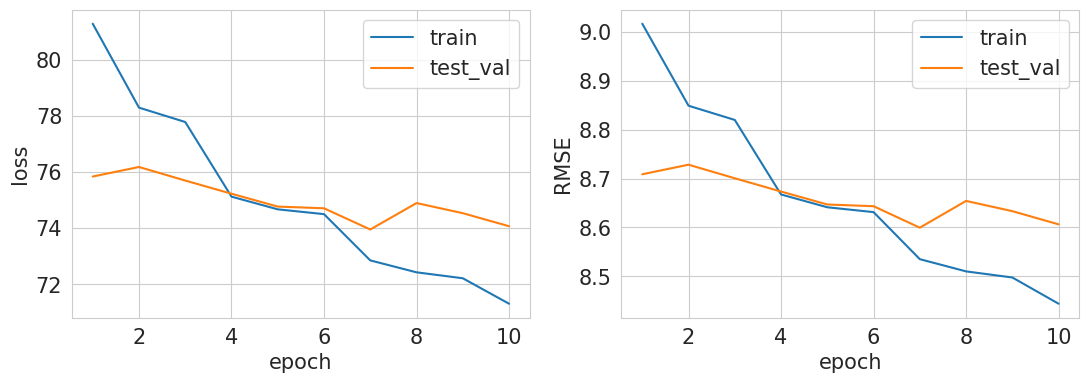

In [253]:
set_random_seed(42)
train_losses, train_accuracies = [], []
val_losses, val_accuracies = [], [] # Это нужно для отрисовки графиков
otchet = [] #Это для итогового отчета

for i in range (10):
  device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
  loss_train = train(model, optimizer, criterion, train_loader, scheduler)[1] #Обучаем и берем нормальный лосс (поэтому индекс 1)
  loss_test = test(model, criterion, test_val_loader)[0] #Тестим на валидации и берем лосс (индекс 0)
  loss_test_itog = test(model, criterion, test_loader)[0]
  train_losses.append(loss_train) #Добавляем все лоссы в списки
  val_losses.append(loss_test)
  train_accuracies.append(RMSE(loss_train))
  val_accuracies.append(RMSE(loss_test))

  otchet.append(f'Epoch: {i + 1}, RMSE_train:{RMSE(loss_train)}, RMSE_test_val:{RMSE(loss_test)} \n') #Добавляем запись в отчет (в конце выведем его)

  plot_losses(train_losses, val_losses, train_accuracies, val_accuracies)

In [254]:
print(*otchet)
loss_itog_test = test(model, criterion, test_loader)[0] # Считаем метрику на тестовой финальной выборке
print(f'Финальное RMSE, полученное на тестовой выборке: {loss_itog_test**(1/2)}')

Epoch: 1, RMSE_train:9.016264027993751, RMSE_test_val:8.708708929854708 
 Epoch: 2, RMSE_train:8.848743632410153, RMSE_test_val:8.728265399084712 
 Epoch: 3, RMSE_train:8.81970422329784, RMSE_test_val:8.700531933763134 
 Epoch: 4, RMSE_train:8.66744130362561, RMSE_test_val:8.673447361430382 
 Epoch: 5, RMSE_train:8.641298601121706, RMSE_test_val:8.646956074598009 
 Epoch: 6, RMSE_train:8.631374630529997, RMSE_test_val:8.643472852301784 
 Epoch: 7, RMSE_train:8.535276214843492, RMSE_test_val:8.599603906376569 
 Epoch: 8, RMSE_train:8.510303902992659, RMSE_test_val:8.654240306823274 
 Epoch: 9, RMSE_train:8.497849003274634, RMSE_test_val:8.633356112837822 
 Epoch: 10, RMSE_train:8.444242337534764, RMSE_test_val:8.60640968516347 



  0%|          | 0/1614 [00:00<?, ?it/s]

Финальное RMSE, полученное на тестовой выборке: 8.739956170821536


Далее вставила пару моделей из эксперемнтов, пусть будут

In [ ]:
#model = nn.Sequential(
#    nn.Linear(
#        90, 80
#),
#    nn.ReLU(),
#    nn.Linear(
#        80, 60
#),
#    nn.ReLU(),
#    nn.Linear(
#        60, 30
#),
#    nn.ReLU(),
#    nn.Linear(
#        30, 1
#),
#    )
#
#learning_rate = 0.001
#beta1 = 0.9
#beta2 = 0.999
#eps = 1e-8

#optimizer = optim.Adam(model.parameters(), lr=learning_rate, betas=(beta1, beta2), eps=eps)
#criterion = nn.MSELoss() # Критерий

#scheduler = None

In [248]:
#model = nn.Sequential(
#    nn.Linear(
#        90, 80
#),
#    nn.ReLU(),
#    nn.Linear(
#        80, 60
#),
#    nn.ReLU(),
#    nn.Linear(
#        60, 30
#),
#    nn.ReLU(),
#    nn.Linear(
#        30, 1
#),
#    )
#
#lr = 0.001
#momentum = 0.9



#optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum)
#criterion = nn.MSELoss() # Критерий

#scheduler = None

## Задание 3. (0 баллов, но при невыполнении максимум за все задание &mdash; 0 баллов)

Напишите небольшой отчет о том, как вы добились полученного качества: какие средства использовали и какие эксперименты проводили. Подробно расскажите об архитектурах и значениях гиперпараметров, а также какие метрики на тесте они показывали. Чтобы отчет был зачтен, необходимо привести хотя бы 3 эксперимента.

Начнем с того, что сначала я не отнормировала таргет. Перепробовала очень много разных архитектур, оптимизаторов и прочего, но RMSE не опускалась ниже 10.9. Поэтому описание экспериментов начну с модели, которая показала лучший результат на неотнормированном таргете.
Модель 1:
model = nn.Sequential(
    nn.Linear(
        90, 80
),
    nn.ReLU(),
    nn.Linear(
        80, 60
),
    nn.ReLU(),
    nn.Linear(
        60, 30
),
    nn.ReLU(),
    nn.Linear(
        30, 1
),
    )

lr = 0.001
momentum = 0.9

optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum)
criterion = nn.MSELoss() # Критерий

scheduler = None

Эксперемент 1: меняем гиперпараметры
1. lr = 0.001 и momentum = 0.9 дают 8.84 на 8 эпохе
2. lr = 0.0001 и momentum = 0.9 - 8.91 на 11 эпохе
3. lr = 0.001 и momentum = 0.8 - 8.83 на 11 эпохе

Эксперемент 2:  Добавила torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm), max_grad_norm = 1.0, lr = 0.001, momentum = 0.8 - 8.84 на 10 эпохе
1. torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm), max_grad_norm = 1.0, lr = 0.001, momentum = 0.9 - 8.84 на 7 эпохе
2. torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm), max_grad_norm = 1.0, lr = 0.01, momentum = 0.9 - 8.84 на 2 эпохе, но далее ошибка пошла вверх
3. torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm), max_grad_norm = 2.0, lr = 0.01, momentum = 0.9 - 8.82 на 2 эпохе, но далее была нестабильная и ниже 8.83 не опустилась
4. torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm), max_grad_norm = 0.9, lr = 0.01, momentum = 0.9 - 8.82 на 2 эпохе
5. torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm), max_grad_norm = 0.9, lr = 0.001, momentum = 0.9 - 8.82 на 7 эпохе

Эсперимент 3: Поменяла оптимизатор на адам с такими параметрами: learning_rate = 0.001
beta1 = 0.9
beta2 = 0.999
eps = 1e-8

optimizer = optim.Adam(model.parameters(), lr=learning_rate, betas=(beta1, beta2), eps=eps) - 8.81 на 2 эпохе
1. убрала torch.nn.utils.clip_grad_norm - 8.81 на 2 эпохе
2. убрала beta1 = 0.9
beta2 = 0.999
eps = 1e-8 - 8.80 на 2 эпохе, далее ошибка растет
3. learning_rate = 0.0001 - 8.80 на 12 эпохе
4. вернула torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm) - 8.80 на 12 эпохе

Эксперимент 4: Поменяла оптимизатор обратно на сгд optim.SGD(model.parameters(), lr=lr, momentum=momentum) и добавила шедулер, который мы использовали на семинаре torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10) - 8.82 на 9 эпохе

Эксперемент 5:
Взяла шедулер scheduler = StepLR(optimizer, step_size=3, gamma=0.3)
1. Еще добавила гиперпараметр weight_decay = 0.001, потому что модель стала переобучаться - 8.80 на 8 эпохе получилось
2. Здесь я много раз подбирала step_size и gamma, при lr= 0.001 хорошие показатели (где-то 8.79 - 8.77) давали модели с дропаутом и step_size = 8-10, gamma = 1.0 -1.5
3. Добавида два дропаута для борьбы с переобучением - получился результат 8.74 на 11 эпохе (это вторая модель)
4. Добавила дропаут после первого линейного слоя с p=0.1 - стало 8.73 на 10 эпохе (я тоже оставила этот эксперимент)
5. На всякий случай еще сделала уменьшение lr без шедулера через цикл - тоже дало 8.75 (самая первая модель)

До этого (когда еще не отнормировала таргет) пробовала разные архитектуры: 1-6 линейных слоев, но остановилась на 4х, тк и без\и после нормировки таргета такая архитектура давала мне наилучший результат